# 1. Setup

## 1.1 Install Dependencies

In [1]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip install opencv-python
!pip install opencv-contrib-python

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1.2 Import Dependencies

In [5]:
# Import standard dependencies
import cv2
import os
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import TensorFlow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf


## 1.3: Set GPU Growth

In [ ]:
# If using GPU, limit processing within reasonable bounds
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

## 1.4: Create Folder Structures

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)


In [11]:
POS_PATH

'data\\positive'

# 2. Collect Positives and Anchors

## 2.1: Collect LFW Dataset

In [79]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw-deepfunneled') :
  for file in os.listdir(os.path.join('lfw-deepfunneled', directory)) :
    EX_PATH = os.path.join('lfw-deepfunneled', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart
lfw-deepfunneled\lfw-deepfunneled\Aaron_Guiel
lfw-deepfunneled\lfw-deepfunneled\Aaron_Patterson
lfw-deepfunneled\lfw-deepfunneled\Aaron_Peirsol
lfw-deepfunneled\lfw-deepfunneled\Aaron_Pena
lfw-deepfunneled\lfw-deepfunneled\Aaron_Sorkin
lfw-deepfunneled\lfw-deepfunneled\Aaron_Tippin
lfw-deepfunneled\lfw-deepfunneled\Abbas_Kiarostami
lfw-deepfunneled\lfw-deepfunneled\Abba_Eban
lfw-deepfunneled\lfw-deepfunneled\Abdel_Aziz_Al-Hakim
lfw-deepfunneled\lfw-deepfunneled\Abdel_Madi_Shabneh
lfw-deepfunneled\lfw-deepfunneled\Abdel_Nasser_Assidi
lfw-deepfunneled\lfw-deepfunneled\Abdoulaye_Wade
lfw-deepfunneled\lfw-deepfunneled\Abdulaziz_Kamilov
lfw-deepfunneled\lfw-deepfunneled\Abdullah
lfw-deepfunneled\lfw-deepfunneled\Abdullah_Ahmad_Badawi
lfw-deepfunneled\lfw-deepfunneled\Abdullah_al-Attiyah
lfw-deepfunneled\lfw-deepfunneled\Abdullah_Gul
lfw-deepfunneled\lfw-deepfunneled\Abdullah_Nasseef
lfw-deepfunneled\lfw-deepfunneled\Abdullatif_Sener
lfw-deepfu

In [81]:
for directory in os.listdir('data/negative') :
  for file in os.listdir(os.path.join('data/negative', directory)) :
    EX_PATH = os.path.join('data/negative', directory, file)
    print(EX_PATH)

data/negative\Aaron_Eckhart\Aaron_Eckhart_0001.jpg
data/negative\Aaron_Guiel\Aaron_Guiel_0001.jpg
data/negative\Aaron_Patterson\Aaron_Patterson_0001.jpg
data/negative\Aaron_Peirsol\Aaron_Peirsol_0001.jpg
data/negative\Aaron_Peirsol\Aaron_Peirsol_0002.jpg
data/negative\Aaron_Peirsol\Aaron_Peirsol_0003.jpg
data/negative\Aaron_Peirsol\Aaron_Peirsol_0004.jpg
data/negative\Aaron_Pena\Aaron_Pena_0001.jpg
data/negative\Aaron_Sorkin\Aaron_Sorkin_0001.jpg
data/negative\Aaron_Sorkin\Aaron_Sorkin_0002.jpg
data/negative\Aaron_Tippin\Aaron_Tippin_0001.jpg
data/negative\Abbas_Kiarostami\Abbas_Kiarostami_0001.jpg
data/negative\Abba_Eban\Abba_Eban_0001.jpg
data/negative\Abdel_Aziz_Al-Hakim\Abdel_Aziz_Al-Hakim_0001.jpg
data/negative\Abdel_Madi_Shabneh\Abdel_Madi_Shabneh_0001.jpg
data/negative\Abdel_Nasser_Assidi\Abdel_Nasser_Assidi_0001.jpg
data/negative\Abdel_Nasser_Assidi\Abdel_Nasser_Assidi_0002.jpg
data/negative\Abdoulaye_Wade\Abdoulaye_Wade_0001.jpg
data/negative\Abdoulaye_Wade\Abdoulaye_Wade_0002

In [83]:
# Move image files from name directories to higher negative directory
for directory in os.listdir('data/negative') :
  for file in os.listdir(os.path.join('data/negative', directory)) :
    EX_PATH = os.path.join('data/negative', directory, file)
    NEW_PATH = os.path.join(NEG_PATH, file)
    os.replace(EX_PATH, NEW_PATH)

In [85]:
# Delete name directories to ensure there are only images in the negative directory
for entry in os.scandir('data/negative') :
  if entry.is_dir() :
    os.rmdir(entry.path)

## 2.2: Collect Positive and Anchor Classes

In [ ]:
# Code from Colab camera integration (initial attempt)
# I used Colab first because of the option of a virtual GPU to quicken the training process, but there are restrictions on virtual resources. 
# I ended up .
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = 250;
      canvas.height = 250;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


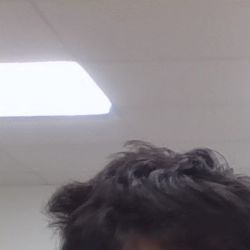

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

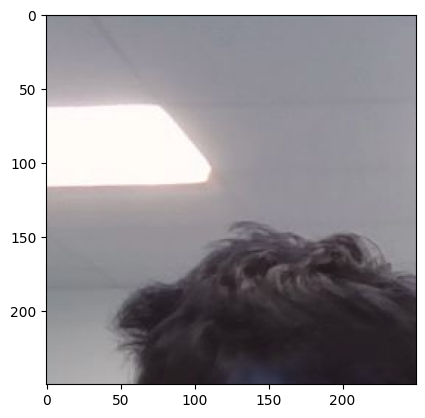

In [ ]:
image = cv2.imread('photo.jpg')

plt.imshow(image[200:200+250, 200:200+250, :])


In [ ]:
# OpenCV method for positive and anchor data collection
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
  ret, frame = cap.read()

  frame = frame[170:170+250, 180:180+250, :]

  # Collect anchors
  if cv2.waitKey(1) & 0XFF == ord('a'):
      # Create the unique file path
      imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
      # Write out anchor image
      cv2.imwrite(imgname, frame)
    

  # Collect positives
  if cv2.waitKey(1) & 0XFF == ord('p'):
      # Create the unique file path
      imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
      # Write out anchor image
      cv2.imwrite(imgname, frame)
    
  # Show image back to screen
  cv2.imshow('Image Collection', frame)
  

  # Breaking gracefully
  if cv2.waitKey(1) & 0XFF == ord('q'):
    break

# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [ ]:
# Unzip files
!unzip /anchor.zip

Archive:  /anchor.zip
   creating: anchor/
  inflating: anchor/12d7862c-b2b2-11ef-a5a6-d8f883a00ac7.jpg  
  inflating: anchor/12e5b992-b2b2-11ef-b9d6-d8f883a00ac7.jpg  
  inflating: anchor/12ea8957-b2b2-11ef-b6a4-d8f883a00ac7.jpg  
  inflating: anchor/156f52df-b2b2-11ef-bf4c-d8f883a00ac7.jpg  
  inflating: anchor/162b6fbc-b2b2-11ef-93d8-d8f883a00ac7.jpg  
  inflating: anchor/16885970-b2b2-11ef-87c4-d8f883a00ac7.jpg  
  inflating: anchor/1694b292-b2b2-11ef-920a-d8f883a00ac7.jpg  
  inflating: anchor/1699690a-b2b2-11ef-953f-d8f883a00ac7.jpg  
  inflating: anchor/16ade886-b2b2-11ef-8115-d8f883a00ac7.jpg  
  inflating: anchor/16b2bd12-b2b2-11ef-87cb-d8f883a00ac7.jpg  
  inflating: anchor/16b75636-b2b2-11ef-acf5-d8f883a00ac7.jpg  
  inflating: anchor/1722ed6d-b2b2-11ef-87f3-d8f883a00ac7.jpg  
  inflating: anchor/178b79c0-b2b2-11ef-a1b8-d8f883a00ac7.jpg  
  inflating: anchor/1799cfc9-b2b2-11ef-8de5-d8f883a00ac7.jpg  
  inflating: anchor/17a14376-b2b2-11ef-b90c-d8f883a00ac7.jpg  
  inflating:

In [ ]:
# Move LFW Images to the following repository data/positive and data/anchor
import os
import shutil

# Move LFW Images to the following repository data/positive and data/anchor
for item in os.listdir('positive_unzip'):
    item_path = os.path.join('positive_unzip', item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # If it's a file, move it to POS_PATH
        NEW_PATH = os.path.join(POS_PATH, item)
        shutil.move(item_path, NEW_PATH)
    # If it's a directory, process its contents recursively (if needed)
    # elif os.path.isdir(item_path):
    #     # Add logic here to handle directories if necessary

for item in os.listdir('anchor_unzip'):
    item_path = os.path.join('anchor_unzip', item)
    # Check if the item is a file
    if os.path.isfile(item_path):
        # If it's a file, move it to ANC_PATH
        NEW_PATH = os.path.join(ANC_PATH, item)
        shutil.move(item_path, NEW_PATH)
    # If it's a directory, process its contents recursively (if needed)
    # elif os.path.isdir(item_path):
    #     # Add logic here to handle directories if necessary

# 3. Load and Preprocess Images

## 3.1: Get Image Directories

In [7]:
# Create dataset of 300 images from each directory
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)


In [9]:
dir_test = anchor.as_numpy_iterator()

In [91]:
dir_test.next()

b'data\\anchor\\19d68c0b-b2b1-11ef-a66f-d8f883a00ac7.jpg'

## 3.2 Preprocessing - Scale and Resize

In [11]:
def preprocess(file_path) :

  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)

  # Preprocessing steps - resizing the image to be 100x100x3
  img = tf.image.resize(img, (100, 100))

  # Scale images between 0 and 1
  img = img / 255.0

  return img

## 3.3: Create Labelled Dataset

In [13]:
# (anchor, positive) => 1, 1, 1, 1, 1
# (anchor, negative) => 0, 0, 0, 0, 0

positive = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negative = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positive.concatenate(negative)

In [15]:
samples = data.as_numpy_iterator()
example = samples.next()

## 3.4: Build Train and Test Partition

In [17]:
def preprocess_twin(input_img, validation_img, label) :
  return(preprocess(input_img), preprocess(validation_img), label)

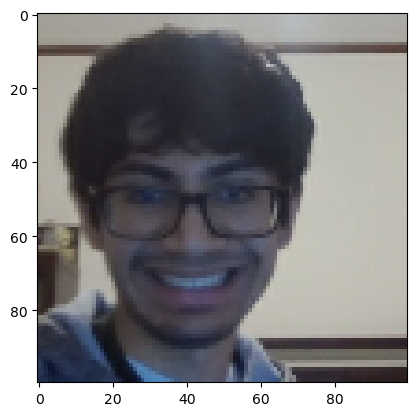

In [105]:
res = preprocess_twin(*example)
plt.imshow(res[1])

In [67]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [109]:
samples = data.as_numpy_iterator()
example = samples.next()


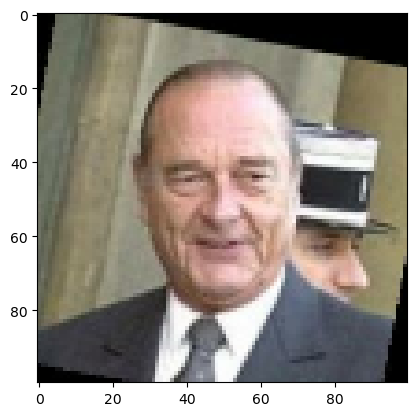

In [111]:
plt.imshow(example[1])

In [89]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)


In [71]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()

In [53]:
len(train_sample[0])

16

In [73]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


# 4. Model Engineering

## 4.1: Build Embedding Layer

In [19]:
inp = Input(shape=(100, 100, 3), name='input_image')

In [25]:
c1 = Conv2D(64, (10, 10), activation='relu')(inp)

In [27]:
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)
m1

<KerasTensor shape=(None, 46, 46, 64), dtype=float32, sparse=False, name=keras_tensor_1>

In [21]:
def make_embedding() :
  inp = Input(shape=(100, 100, 3), name='input_image')

  # First Block
  c1 = Conv2D(64, (10, 10), activation='relu')(inp)
  m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

  # Second Block
  c2 = Conv2D(128, (7, 7), activation='relu')(m1)
  m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

  # Third Block
  c3 = Conv2D(128, (4, 4), activation='relu')(m2)
  m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

  # Final Embedding Block
  c4 = Conv2D(256, (4, 4), activation='relu')(m3)
  f1 = Flatten()(c4)
  d1 = Dense(4096, activation='sigmoid')(f1)


  return Model(inputs=inp, outputs=d1, name='embedding')

In [23]:
embedding = make_embedding()

In [33]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2: Build Distance Layer

In [25]:
# Siamese L1 Distance class
class LDist(Layer) :

  # Init method - inheritance
  def __init__(self, **kwargs) :
    super().__init__()

  # Similarity calculation
  def call(self, input_embedding, validation_embedding) :
    return tf.math.abs(input_embedding - validation_embedding)

## 4.3: Make Siamese Model

In [27]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_image', shape=(100, 100, 3))

In [29]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [31]:
def make_siamese_model() :

  # Handle inputs
  input_image = Input(name='input_img', shape=(100, 100, 3))
  validation_image = Input(name='validation_image', shape=(100, 100, 3))

  # Combine siamese distance components
  siamese_layer = LDist()
  siamese_layer._name = 'distance'
  distances = siamese_layer(embedding(input_image), embedding(validation_image))

  # Classifcation Layer
  classifier = Dense(1, activation='sigmoid')(distances)

  return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [33]:
siamese_layer = LDist()


In [45]:
distances = siamese_layer(inp_embedding, val_embedding)

In [47]:
classifier = Dense(1, activation='sigmoid')(distances)

In [49]:
classifier

<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_16>

In [51]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_dist (LDist)      │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l_dist[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
siamese_model = make_siamese_model()

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_dist_1 (LDist)    │ (None, 4096)      │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l_dist_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1: Setup Loss and Optimizer

In [55]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [37]:
opt = tf.keras.optimizers.Adam(1e-4)

## 5.2 Establish Checkpoints

In [57]:
checkpoints_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoints_dir, 'cpkt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_network=siamese_network)

## 5.3: Build Train Step Function

In [59]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

## 5.4: Build Training Loop

In [61]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints at every 10th epoch
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5: Train the Model

In [147]:
EPOCHS = 50

In [149]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/stepTensor("binary_crossentropy/div_no_nan:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 28s 947ms/step

 Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 902ms/step

 Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step

 Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 963ms/step

 Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 947ms/step

 Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 948ms/step

 Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 951ms/step

 Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 948ms/step

 Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 949ms/step

 Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 953ms/step

 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 24s 897ms/step

 Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 954ms/step

 Epoch 13/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 954ms/step

 Epoch 14/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 949ms/step

 Epoch 15/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 951ms/s

# 6. Evaluate Model

## 6.1: Import Metrics

In [75]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [77]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [79]:
test_var = test_data.as_numpy_iterator().next()

## 6.2: Make Predictions

In [85]:
# Make predictions
y_hat = model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[1.8188186e-10],
       [1.0000000e+00],
       [5.6527858e-09],
       [1.0000000e+00],
       [1.2957951e-12],
       [1.7606247e-03],
       [9.9572229e-01],
       [9.9964362e-01],
       [1.2300202e-09],
       [3.3667891e-10],
       [2.1253155e-10],
       [9.9999982e-01],
       [9.9944758e-01],
       [8.0930612e-08],
       [9.7592407e-01],
       [1.0000000e+00]], dtype=float32)

In [174]:
# Post-processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1]

In [176]:
# Compare with results manually
y_true

array([0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

## 6.3: Calculate Metrics

In [190]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [192]:
# Creating a metric object
m = Precision()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

## 6.4 : Visualize Results

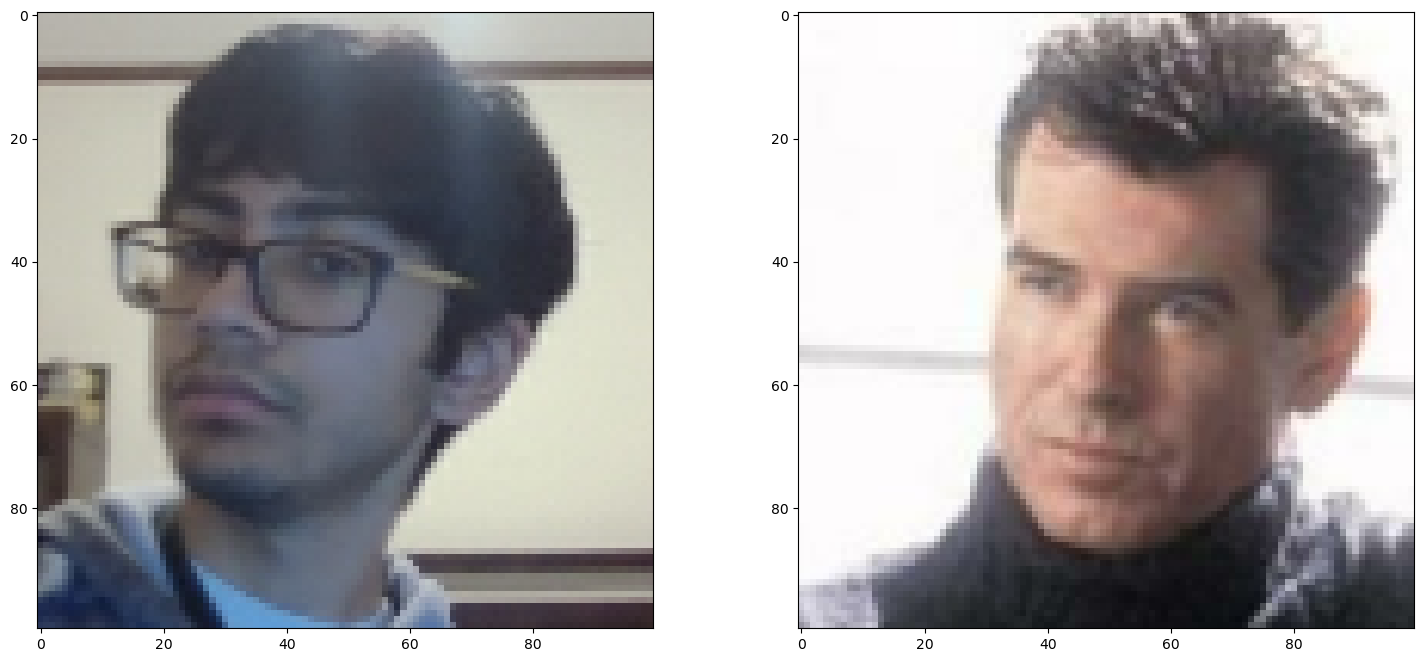

In [204]:
# Set plot size
plt.figure(figsize=(18, 8))

# Set first subplot
plt.subplot(1, 2, 1)
plt.imshow(test_input[4])
plt.subplot(1, 2, 2)
plt.imshow(test_val[4])
plt.show()

## 7: Save Model

In [209]:
siamese_model.save('siamesemodel.keras')

In [83]:
# Reload model
model = tf.keras.models.load_model('siamesemodel.keras', custom_objects={'LDist':LDist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [65]:
model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


array([[2.2784255e-11],
       [1.2999148e-11],
       [7.1049392e-08],
       [1.2759592e-11],
       [1.0000000e+00],
       [7.0288634e-06],
       [1.0000000e+00],
       [8.5409721e-11],
       [9.9997550e-01],
       [1.0000000e+00],
       [5.8981847e-08],
       [9.9999928e-01],
       [1.4097249e-09],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9512750e-01]], dtype=float32)

In [217]:
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l_dist_2 (LDist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │      4,097 │ l_dist_2[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1: Verification Function

In [269]:
import random, shutil
files = []
for file in os.listdir('data/positive') :
    PATH = os.path.join('data/positive', file)
    files.append(PATH)

for i in range(0, 50):
    random_path = files[random.randint(0, len(files))]
    shutil.copy(random_path, 'application_data/verification_images')
    
    

In [87]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2: OpenCV Real Time Verification

In [93]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[170:170+250, 180:180+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.7, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━